In [1]:
# Данные тут
# https://data.seattle.gov/Transportation/Fremont-Bridge-Bicycle-Counter/65db-xm6k
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import datetime

#pip install tscv
import tscv

from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import r2_score, mean_absolute_percentage_error, root_mean_squared_error

In [2]:
temp=pd.read_csv('Fremont_Bridge_Bicycle_Counter.csv')
display(temp.head(3))
temp.info()

,Date,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
0,11/01/2019 12:00:00 AM,12.0,7.0,5.0
1,11/01/2019 01:00:00 AM,7.0,0.0,7.0
2,11/01/2019 02:00:00 AM,1.0,0.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141422 entries, 0 to 141421
Data columns (total 4 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Date                          141422 non-null  object 
 1   Fremont Bridge Total          141400 non-null  float64
 2   Fremont Bridge East Sidewalk  141400 non-null  float64
 3   Fremont Bridge West Sidewalk  141400 non-null  float64
dtypes: float64(3), object(1)
memory usage: 4.3+ MB


In [3]:
df = pd.read_csv('Fremont_Bridge_Bicycle_Counter.csv',
                 index_col='Date',
                 parse_dates = True, date_format='mixed').sort_index()
df = df[~df.index.duplicated(keep='last')]
df = df.dropna()
df = df.drop(['Fremont Bridge East Sidewalk','Fremont Bridge West Sidewalk'],axis=1)
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 75156 entries, 2012-10-03 00:00:00 to 2021-04-30 23:00:00
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Fremont Bridge Total  75156 non-null  float64
dtypes: float64(1)
memory usage: 1.1 MB


None

,Fremont Bridge Total
Date,
2012-10-03 00:00:00,13.0
2012-10-03 01:00:00,10.0
2012-10-03 02:00:00,2.0
2012-10-03 03:00:00,5.0
2012-10-03 04:00:00,7.0


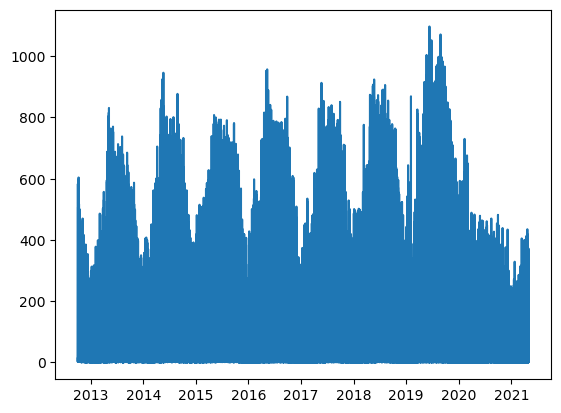

In [4]:
plt.plot(df.index, df['Fremont Bridge Total'])

In [5]:
# Собираем датасет, гарантировано с шагом 1 час и заполнением пропусков целыми числами,
# важно убедится в отсутствии отрицательных значений

data = df.resample('60min').asfreq().interpolate(method='piecewise_polynomial').astype('int')
data['Date_time'] = data.index.to_pydatetime()
data.columns = ['Total','Date_time']
data.head()

,Total,Date_time
Date,,
2012-10-03 00:00:00,13,2012-10-03 00:00:00
2012-10-03 01:00:00,10,2012-10-03 01:00:00
2012-10-03 02:00:00,2,2012-10-03 02:00:00
2012-10-03 03:00:00,5,2012-10-03 03:00:00
2012-10-03 04:00:00,7,2012-10-03 04:00:00


In [6]:
## проверка на осутствие отрицательных поездок
np.where(data.Total>=0,0,1).mean()

0.0

## Кросс-валидации

In [7]:
data_split = data['2019-07':'2019-09']
data_split

X = data_split['Date_time']
y = data_split['Total']

gap_size = 40
X_train, X_test, y_train, y_test = tscv.gap_train_test_split(X, y, test_size = 0.25, gap_size=gap_size)

In [8]:
##### ------------------ ####
cv_GapKFold = tscv.GapKFold( n_splits=3, gap_before= 40, gap_after=40)
#### ------------------ ####
cv_GapWalkForward = tscv.GapWalkForward(
    n_splits = 3,
    max_train_size = 400,
    test_size = 100,
    gap_size = 50)

# ##### ------------------ ####
cv_GapRollForward = tscv.GapRollForward(
        min_train_size=750, 
        max_train_size=750,
        min_test_size=200, 
        max_test_size=200,
        gap_size=50, 
        roll_size=100,
        )
# ##### ------------------ ####

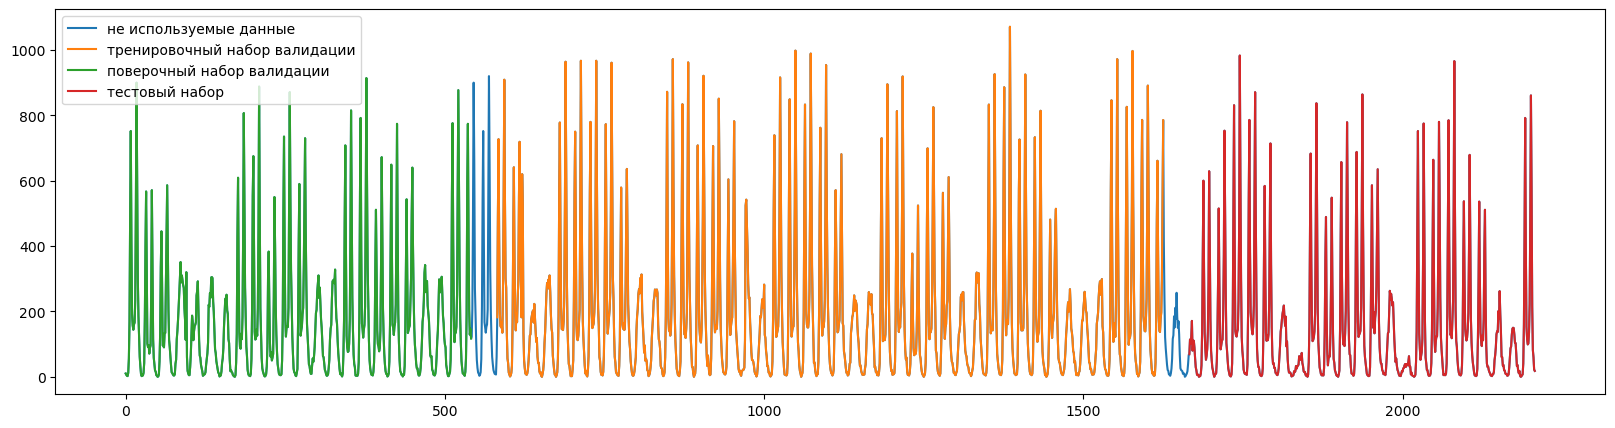

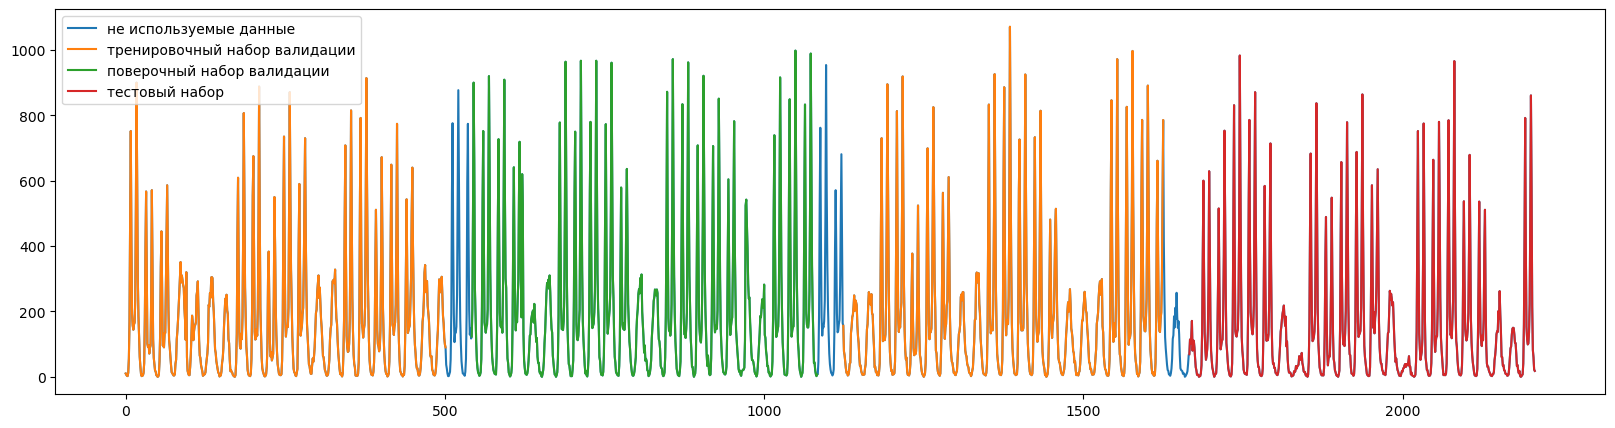

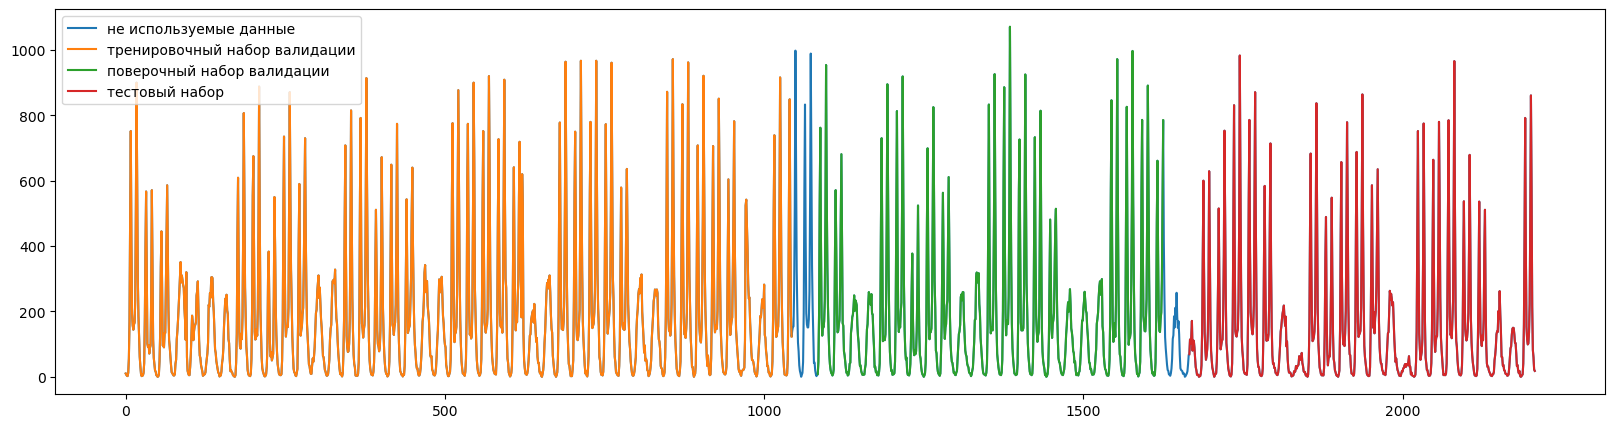

In [9]:
cv = cv_GapKFold

##### ------------------ ####

all_splits = list(cv.split(X_train, y_train))
lst = range(len(list(all_splits)))
ran = range(len(y_train))

for i in lst:
    train_sp, test_sp = all_splits[i]
    df_tmp = pd.DataFrame(index = ran, data = {'1': ran, '2':np.nan}) # избегаем
    df_tmp.iloc[df_tmp[~df_tmp.index.isin(train_sp)].index, 0] = np.nan       # гэпов по оси x
    df_tmp.iloc[train_sp , 1] = y_train.iloc[train_sp]                     #
    train_sp = df_tmp['1'].values                                     #
    plt.figure(figsize=(20, 5))
    plt.plot(range(len(y)), y, label='не используемые данные')
    plt.plot(train_sp, y_train, label='тренировочный набор валидации');
    plt.plot(test_sp, y_train.iloc[test_sp], label='поверочный набор валидации')
    plt.plot(range(len(y_train)+gap_size, len(y_train)+gap_size+len(y_test)), y_test, label='тестовый набор')
    plt.legend()
    plt.show()